## Binary Image Classification Project
### Joel Brandinger

In [2]:
# import libraries
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

### Part 1

In [2]:
# import train data
x_train = np.loadtxt('data_digits_8_vs_9_noisy/x_train.csv', delimiter=',', skiprows=1)
y_train = np.loadtxt('data_digits_8_vs_9_noisy/y_train.csv', delimiter=',', skiprows=1)

# import test data
x_test = np.loadtxt('data_digits_8_vs_9_noisy/x_test.csv', delimiter=',', skiprows=1)
y_test = np.loadtxt('data_digits_8_vs_9_noisy/y_test.csv', delimiter=',', skiprows=1)

In [3]:
# suppress convergance warnings with low max_iter
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

score = []
log_loss = []
weight = []

max_iter = np.arange(1, 41)

for i in max_iter:
    # generate model with i set to max_iter 
    model = linear_model.LogisticRegression(solver='liblinear', max_iter=i)
    model.fit(x_train, y_train)
    
    # calculate score of model
    score.append(model.score(x_train, y_train))
    
    # calculate log loss of model
    y_pred = model.predict(x_train)
    log_loss.append(metrics.log_loss(y_train, y_pred))
    
    # calculate feature weight
    weight.append(model.coef_[0][0])

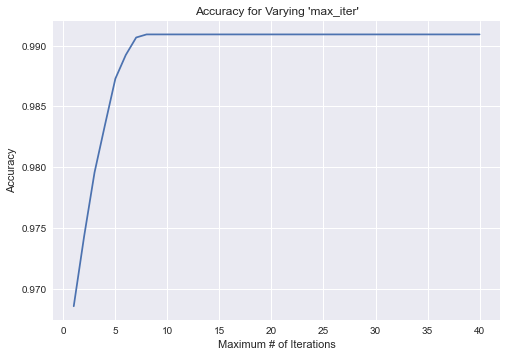

In [4]:
# plot score
plt.plot(max_iter, score)
plt.xlabel('Maximum # of Iterations')
plt.ylabel('Accuracy')
plt.title("Accuracy for Varying 'max_iter'")
plt.show()

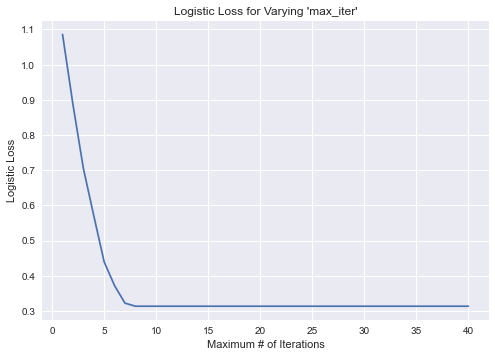

In [5]:
# plot log loss
plt.plot(max_iter, log_loss)
plt.xlabel('Maximum # of Iterations')
plt.ylabel('Logistic Loss')
plt.title("Logistic Loss for Varying 'max_iter'")
plt.show()

**Results:** As seen in the graphs above, increasing the maximum number of allowed iterations for the logisitic regression models results in increased accuracy and decreased log loss up until about 8 max iterations. After this point the graphs level off and the accuracy and score both stay at roughly the same level. Moreover, the accuracy and log loss seem to be inversely correlated, which makes sense since if with higher accuracy you would expected lower loss. 

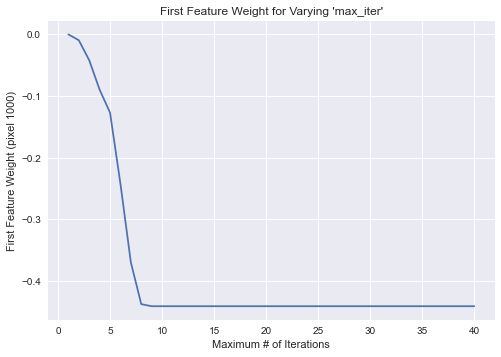

In [6]:
# plot feature weights
plt.plot(max_iter, weight)
plt.xlabel('Maximum # of Iterations')
plt.ylabel('First Feature Weight (pixel 1000)')
plt.title("First Feature Weight for Varying 'max_iter'")
plt.show()

**Results:** The graph above shows us that as we increase the maximum number of iterations for the solver, the first feature weight decreases until about 8 max iterations. This is the same number of iterations where the accuracy and log loss also both level off. Thus, we can deduce that 8 iterations is all the model needs to maximize accuracy, minimize log loss, and find an appropriate feature weight for pixel 1000.

In [7]:
log_loss = []
min_loss = float('inf')
c_grid = np.logspace(-9, 6, 31)

for c in c_grid:
    # fit model to appropriate regularization value
    model = linear_model.LogisticRegression(C=c)
    model.fit(x_train, y_train)
    
    # calculate log loss
    y_pred = model.predict(x_test)
    loss = metrics.log_loss(y_test, y_pred)
    log_loss.append(loss)
    
    if(loss < min_loss):
        min_loss = loss
        c_val = c
        score = model.score(x_test, y_test)

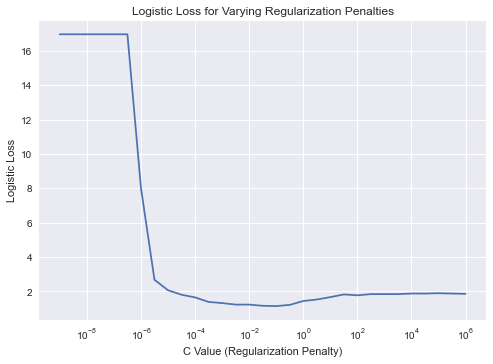

In [8]:
# plot log loss for each regularization
plt.xscale('log')
plt.plot(c_grid, log_loss)
plt.xlabel('C Value (Regularization Penalty)')
plt.ylabel('Logistic Loss')
plt.title("Logistic Loss for Varying Regularization Penalties")
plt.show()

In [9]:
print("Minimum log loss of:", min_loss, "with regularization penalty:", c_val, "and accuracy:", score)

Minimum log loss of: 1.1495637060927246 with regularization penalty: 0.1 and accuracy: 0.9667170953101362


In [10]:
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh=0.5):
    cm = metrics.confusion_matrix(ytrue_N, yproba1_N >= thresh)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    
    return cm_df

In [11]:
# regenerate best model
model = linear_model.LogisticRegression(C=0.1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# print confusion matrix for model
print(calc_confusion_matrix_for_threshold(y_test, y_pred))

Predicted    0    1
True               
0          942   32
1           34  975


In [12]:
false_positives = []
false_negatives = []
for i in range(len(y_test)):
    if(y_pred[i] == 1 and y_test[i] == 0):
        false_positives.append(i)
    
    if(y_pred[i] == 0 and y_test[i] == 1):
        false_negatives.append(i)

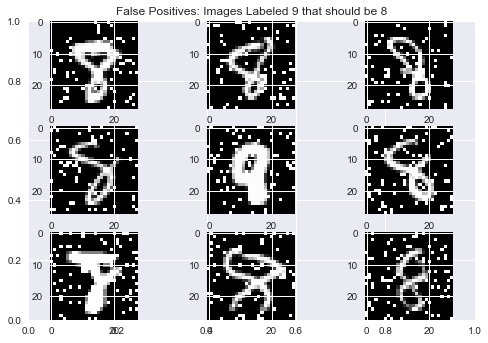

In [15]:
fig, ax = plt.subplots()

for i in range(9):
    fig.add_subplot(3, 3, i+1)
    idx = false_positives[i]
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray', vmin=0.0, vmax=1.0)

ax.set_title("False Positives: Images Labeled 9 that should be 8")
plt.show()

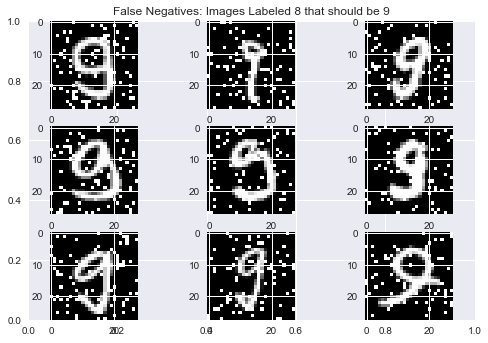

In [17]:
fig, ax = plt.subplots()
for i in range(9):
    fig.add_subplot(3, 3, i+1)
    idx = false_negatives[i]
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray', vmin=0.0, vmax=1.0)

ax.set_title("False Negatives: Images Labeled 8 that should be 9")
plt.show()

**Results** Based on the images of false negatives and false positives it would appear that the images are pretty clear cut 8 and 9s which should indicate no issue with classification. However, since these images are incorrectly classified, I would assume that the error arises from noise around the exterior. My guess is that these extraneous pixels/ features are being incorporated to have significant value when they are just noise. Thus, I believe if we could remeove these white pixels the accuracy of our model would drastically improve.

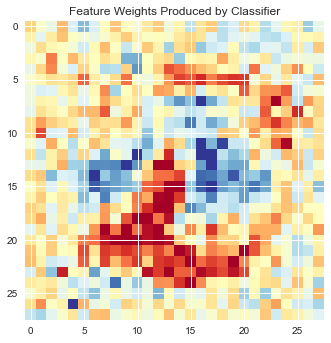

In [18]:
weights = model.coef_.reshape(28, 28)
plt.imshow(weights, cmap='RdYlBu', vmin=-0.5, vmax=0.5)
plt.title("Feature Weights Produced by Classifier")
plt.show()

In [19]:
print(weights[12][10])

0.5246362939118163


**Results** According to the image it appears as if the....

### Part 2

**Ideas for Exploring Data & Transforming Features:**
- regularization strength
- min max scaler
- L1 vs L2 penalties
- best subset feature selection
- forwared stepwise feature selection
- select K Best features
- recursive feture elimination


In [3]:
# import train data
x_train = np.loadtxt('data_trouser_dress/troudress_train_x.csv', delimiter=',', skiprows=1)
y_train = np.loadtxt('data_trouser_dress/troudress_train_y.csv', delimiter=',', skiprows=1)

# import test data
x_test = np.loadtxt('data_trouser_dress/troudress_test_x.csv', delimiter=',', skiprows=1)

In [4]:
def make_folds(x_data, y_data, num_folds):
    
    x_folds = list()
    y_folds = list()
    
    foldLength = (int)(len(x_data) / num_folds)
    start = 0
    
    for fold in range(num_folds):
        end = start + foldLength
        x_folds.append(x_data[start:end])
        y_folds.append(y_data[start:end])
        start = start + foldLength
    
    return x_folds, y_folds

In [5]:
def cross_validate(x, y, num_folds, model):
    
    # generate folds
    xf, yf = make_folds(x, y, num_folds)
    
    sum_train_score = 0
    sum_test_score = 0

    for i in range(num_folds):
        x_test = xf[i] 
        y_test = yf[i]
        
        x_train = xf[:i] + xf[i+1:]
        y_train = yf[:i] + yf[i+1:]
        
        x_train = np.concatenate(x_train)
        y_train = np.concatenate(y_train)
        
        model.fit(x_train, y_train)
        
        train_score = model.score(x_train, y_train)
        test_score = model.score(x_test, y_test)
        
        sum_train_score += train_score
        sum_test_score += test_score

    return (sum_train_score / num_folds), (sum_test_score / num_folds)

In [6]:
def regularization_penalty(pen):
    best_test_score = 0
    train_score = []
    test_score = []

    c_grid = np.logspace(-9, 6, 31)

    for c in c_grid:

        # generate model to appropriate regularization value
        model = linear_model.LogisticRegression(penalty=pen, C=c, solver='liblinear')

        # calculate cross validated accuracy
        train_acc, test_acc = cross_validate(x_train, y_train, 5, model)
        train_score.append(train_acc)
        test_score.append(test_acc)

        if (test_acc > best_test_score):
            best_test_score = test_acc
            score_c_val = c
    
    return train_score, test_score, best_test_score, score_c_val

In [25]:
train_score, test_score, best_test_score, score_c_val = regularization_penalty('l2')
print("Highest accuracy of:", best_test_score, "with regularization penalty", score_c_val)

Highest accuracy of: 0.9540833333333334 with regularization penalty 0.01


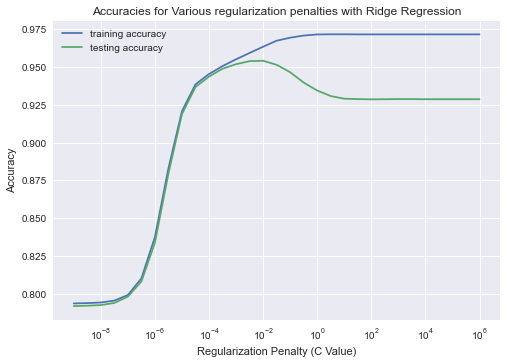

In [26]:
# plot cross validated accuracies
plt.xscale('log')
plt.plot(c_grid, train_score, label='training accuracy')
plt.plot(c_grid, test_score, label='testing accuracy')
plt.xlabel('Regularization Penalty (C Value)')
plt.ylabel('Accuracy')
plt.title("Accuracies for Various regularization penalties with Ridge Regression")
plt.legend()
plt.show()

In [27]:
train_score, test_score, best_test_score, score_c_val = regularization_penalty('l1')
print("Highest accuracy of:", best_test_score, "with regularization penalty", score_c_val)

Highest accuracy of: 0.9549166666666666 with regularization penalty 0.1


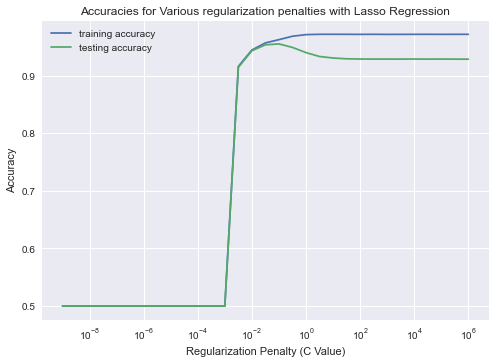

In [29]:
# plot cross validated accuracies
plt.xscale('log')
plt.plot(c_grid, train_score, label='training accuracy')
plt.plot(c_grid, test_score, label='testing accuracy')
plt.xlabel('Regularization Penalty (C Value)')
plt.ylabel('Accuracy')
plt.title("Accuracies for Various regularization penalties with Lasso Regression")
plt.legend()
plt.show()

In [32]:
# regenerate best model
model = linear_model.LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
model.fit(x_train, y_train)
y_pred = model.predict(x_train)

# print confusion matrix for model
print(calc_confusion_matrix_for_threshold(y_train, y_pred))

Predicted     0     1
True                 
0          5835   165
1           286  5714


In [33]:
false_positives = []
false_negatives = []
for i in range(len(y_train)):
    if(y_pred[i] == 1 and y_train[i] == 0):
        false_positives.append(i)
    
    if(y_pred[i] == 0 and y_train[i] == 1):
        false_negatives.append(i)

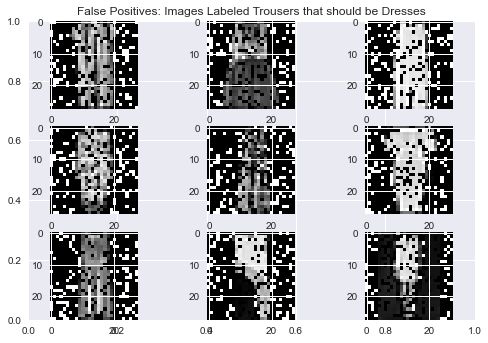

In [35]:
fig, ax = plt.subplots()
for i in range(9):
    fig.add_subplot(3, 3, i+1)
    idx = false_positives[i]
    plt.imshow(x_train[idx].reshape(28, 28), cmap='gray', vmin=0.0, vmax=1.0)

ax.set_title("False Positives: Images Labeled Trousers that should be Dresses")
plt.show()

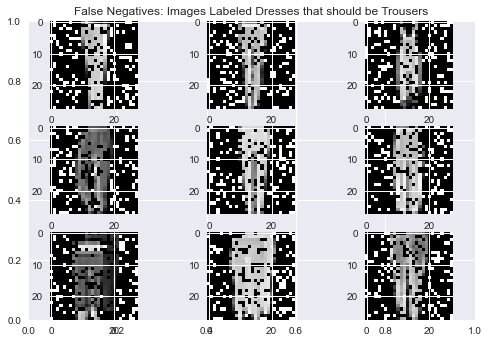

In [36]:
fig, ax = plt.subplots()
for i in range(9):
    fig.add_subplot(3, 3, i+1)
    idx = false_negatives[i]
    plt.imshow(x_train[idx].reshape(28, 28), cmap='gray', vmin=0.0, vmax=1.0)

ax.set_title("False Negatives: Images Labeled Dresses that should be Trousers")
plt.show()

In [38]:
model = linear_model.LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
train_score, test_score = cross_validate(x_train, y_train, 5, model)
print(train_score, test_score)

0.9622708333333334 0.9548333333333334


In [39]:
# scale data
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)

# calculate accuracy
model = linear_model.LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
train_score, test_score = cross_validate(x_train_scaled, y_train, 5, model)
print(train_score, test_score)

0.9622708333333334 0.9549166666666666


In [7]:
# remove white pixels on training data
new_x_train = x_train.copy()

for i, x in enumerate(x_train):
    for j, y in enumerate(x_train[i]):
        if y == 1.0:
            new_x_train[i][j] = 0.0
        else:
            new_x_train[i][j] = y

In [8]:
# remove white pixels on testing data
new_x_test = x_test.copy()

for i, x in enumerate(x_test):
    for j, y in enumerate(x_test[i]):
        if y == 1.0:
            new_x_test[i][j] = 0.0
        else:
            new_x_test[i][j] = y

In [42]:
# calculate new accuracy
model = linear_model.LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
train_score, test_score = cross_validate(new_x_train, y_train, 5, model)
print(train_score, test_score)

0.9752708333333333 0.9719166666666667


In [93]:
# sum pixels to create single feature vectors
x_train_sum = []
for x in new_x_train:
    x_train_sum.append(x.sum())

x_train_sum = np.array(x_train_sum)
x_train_sum = x_train_sum.reshape(-1, 1)

# testing data
x_test_sum = []
for x in new_x_test:
    x_test_sum.append(x.sum())

x_test_sum = np.array(x_test_sum)
x_test_sum = x_test_sum.reshape(-1, 1)

# model = linear_model.LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
# train_score, test_score = cross_validate(x_train_sum, y_train, 5, model)
# print(train_score, test_score)

In [45]:
# flip image horizontally and add to training data
x_train_fliplr = np.fliplr(new_x_train)
big_x_train = np.row_stack((new_x_train, x_train_fliplr))

big_y_train = np.append(y_train, y_train)

# model = linear_model.LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
# train_score, test_score = cross_validate(big_x_train, big_y_train, 5, model)
# print(train_score, test_score)

0.95053125 0.9363333333333334


In [43]:
from sklearn.decomposition import PCA
train_scores = []
test_scores = []

best = 0
num = 0

for nc in range(10, 50):
    pca
    model = linear_model.LogisticRegression(fit_intercept=False, penalty='l2', C=0.31622776601683794, solver='liblinear')
    train_score, test_score = cross_validate(pca_x_train, y_train, 5, model)
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    if (test_score > best):
        best = test_score
        num = nc
    
    
print(best, num)

0.9713333333333333 23


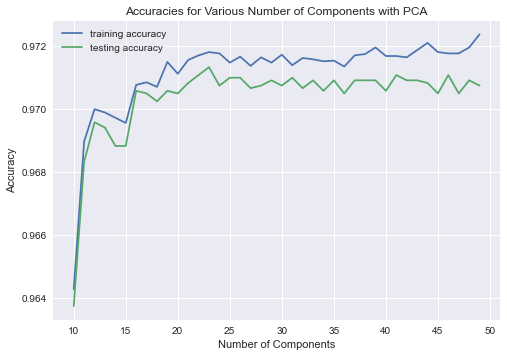

In [45]:
plt.plot(range(10, 50), train_scores, label='training accuracy')
plt.plot(range(10, 50), test_scores, label='testing accuracy')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title("Accuracies for Various Number of Components with PCA")
plt.legend()
plt.show()

In [59]:
model = linear_model.LogisticRegression(penalty='l2', C=0.03162277660168379, solver='liblinear')
train_score, test_score = cross_validate(new_x_train, y_train, 5, model)
print(test_score)

model = linear_model.LogisticRegression(penalty='l2', C=0.01, solver='liblinear')
train_score, test_score = cross_validate(new_x_train, y_train, 5, model)
print(test_score)

model = linear_model.LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
train_score, test_score = cross_validate(new_x_train, y_train, 5, model)
print(test_score)

0.9721666666666667
0.9718333333333333
0.9720833333333333


In [110]:
# convert to only 0s and 1s
sharp_x_train = new_x_train.copy()

for i, x in enumerate(new_x_train):
    for j, y in enumerate(new_x_train[i]):
        if y < 0.5:
            sharp_x_train[i][j] = 0.0
        else:
            sharp_x_train[i][j] = 1.0
            
# convert to only 0s and 1s
sharp_x_test = new_x_test.copy()

for i, x in enumerate(new_x_test):
    for j, y in enumerate(new_x_test[i]):
        if y < 0.5:
            sharp_x_test[i][j] = 0.0
        else:
            sharp_x_test[i][j] = 1.0

In [16]:
print(new_x_train.shape, new_x_test.shape)

(12000, 784) (2000, 784)


In [106]:
pca = PCA(n_components=23)
pca_x_train = pca.fit_transform(new_x_train)

pca_x_test = pca.transform(new_x_test)

In [111]:
model = linear_model.LogisticRegression(penalty='l2', C=0.01, solver='liblinear')
model.fit(sharp_x_train, y_train)
print(model.score(sharp_x_train, y_train))

yproba1_test = model.predict_proba(sharp_x_test)[:, 1]
np.savetxt('yproba1_test.txt', yproba1_test)

0.95925


In [112]:
model = linear_model.LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
model.fit(sharp_x_train, y_train)
print(model.score(sharp_x_train, y_train))

yproba1_test = model.predict_proba(sharp_x_test)[:, 1]
np.savetxt('yproba1_test.txt', yproba1_test)

0.9606666666666667


In [116]:
model = linear_model.LogisticRegression(penalty='l2', C=0.03162277660168379, solver='liblinear')
model.fit(new_x_train, y_train)
print(model.score(new_x_train, y_train))

yproba1_test = model.predict_proba(new_x_test)[:, 1]
np.savetxt('yproba1_test.txt', yproba1_test)

0.9761666666666666


In [115]:
best_test_score = 0

c_grid = np.logspace(-3, 2, 11)

for c in c_grid:

    # generate model to appropriate regularization value
    model = linear_model.LogisticRegression(penalty='l2', C=c, solver='liblinear')

    # calculate cross validated accuracy
    train_acc, test_acc = cross_validate(new_x_train, y_train, 5, model)

    if (test_acc > best_test_score):
        best_test_score = test_acc
        score_c_val = c
    
print(best_test_score, score_c_val)

0.9721666666666667 0.03162277660168379


In [10]:
from skimage import filters, feature

def v_filter(dataset):
    dataset_v = []
    for i, im in enumerate(dataset):
        dataset_v.append(filters.prewitt_v(im.reshape(28,28)).reshape(-1))
    return np.array(dataset_v)

def h_filter(dataset):
    dataset_h = []
    for i, im in enumerate(dataset):
        dataset_h.append(filters.prewitt_h(im.reshape(28,28)).reshape(-1))
    return np.array(dataset_h)

def s_filter(dataset):
    dataset_s = []
    for i, im in enumerate(dataset):
        dataset_s.append(filters.sobel(im.reshape(28,28)).reshape(-1))
    return np.array(dataset_s)

def c_filter(dataset):
    dataset_c = []
    for i, im in enumerate(dataset):
        dataset_c.append(feature.canny(im.reshape(28,28)).reshape(-1))
    return np.array(dataset_c)

In [11]:
dataset_c = c_filter(new_x_train)
dataset_v = v_filter(new_x_train)
dataset_h = h_filter(new_x_train)
dataset_s = s_filter(new_x_train)



dataset_c_test = c_filter(new_x_test)
dataset_v_test = v_filter(new_x_test)
dataset_h_test = h_filter(new_x_test)
dataset_s_test = s_filter(new_x_test)

In [83]:
from sklearn.decomposition import PCA
def get_pca(m):

    pca_c = PCA(n_components=m)
    pca_c.fit(dataset_c)

    pca_v = PCA(n_components=m)
    pca_v.fit(dataset_v)

    pca_h = PCA(n_components=m)
    pca_h.fit(dataset_h)

    pca_s = PCA(n_components=m)
    pca_s.fit(dataset_s)

    pca = PCA(n_components=m)
    pca.fit(new_x_train)
    
    PCA_transform = pca.transform(new_x_train)
    PCA_transform_v = pca_v.transform(dataset_v)
    PCA_transform_h = pca_h.transform(dataset_h)
    PCA_transform_s = pca_s.transform(dataset_s)
    PCA_transform_c = pca_s.transform(dataset_c)


    PCA_transform_test = pca.transform(new_x_test)
    PCA_transform_v_test = pca_v.transform(dataset_v_test)
    PCA_transform_h_test = pca_h.transform(dataset_h_test)
    PCA_transform_s_test = pca_s.transform(dataset_s_test)
    PCA_transform_c_test = pca_s.transform(dataset_c_test)

    pca_x_train = np.hstack(( PCA_transform_s, PCA_transform, PCA_transform_v, PCA_transform_h, PCA_transform_c))
    pca_x_test = np.hstack(( PCA_transform_s_test, PCA_transform_test, PCA_transform_v_test, PCA_transform_h_test, PCA_transform_c_test))
    
    return pca_x_train, pca_x_test

In [91]:
pca_x_train, pca_x_test = get_pca(36)
print(pca_x_train.shape, pca_x_test.shape)


(12000, 180) (2000, 180)


In [81]:
# scaler = MinMaxScaler()
# pca_x_train = scaler.fit_transform(pca_x_train)
# pca_x_test = scaler.transform(pca_x_test)
# print(pca_x_train)

[[0.36958842 0.69626428 0.28963248 ... 0.60771014 0.50233596 0.48612531]
 [0.24998664 0.66600342 0.58227083 ... 0.38493228 0.66015599 0.26611846]
 [0.44773566 0.50944983 0.21438962 ... 0.5816298  0.34746953 0.40570047]
 ...
 [0.12170985 0.39100819 0.5786228  ... 0.35431138 0.53267051 0.47786637]
 [0.39334453 0.47371973 0.12284488 ... 0.71216605 0.45168773 0.60523032]
 [0.30296283 0.48006609 0.23153014 ... 0.46667363 0.56779843 0.31876605]]


In [92]:
model = linear_model.LogisticRegression(fit_intercept=False, solver='liblinear', penalty='l2', C=0.31622776601683794).fit(pca_x_train, y_train)
print(model.score(pca_x_train, y_train))

yproba1_test = model.predict_proba(pca_x_test)[:, 1]
np.savetxt('yproba1_test.txt', yproba1_test)

0.9809166666666667


In [88]:
c_grid = np.logspace(-9, 6, 31)
score = 0

for c in c_grid:
    model = linear_model.LogisticRegression(fit_intercept=False, solver='liblinear', penalty='l2', C=c).fit(pca_x_train, y_train)
    
    sc = model.score(pca_x_train, y_train)
    if (sc > score):
        score = sc
        c_val = c
        

print(score, c_val)

0.9803333333333333 0.31622776601683794


In [89]:
train_scores = []
test_scores = []

best = 0
num = 0

for nc in range(10, 50):
    pca_x_train, pca_x_test = get_pca(nc)
    model = linear_model.LogisticRegression(fit_intercept=False, penalty='l2', C=0.31622776601683794, solver='liblinear')
    train_score, test_score = cross_validate(pca_x_train, y_train, 5, model)
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    if (test_score > best):
        best = test_score
        num = nc
    
    
print(best, num)

0.9775 36


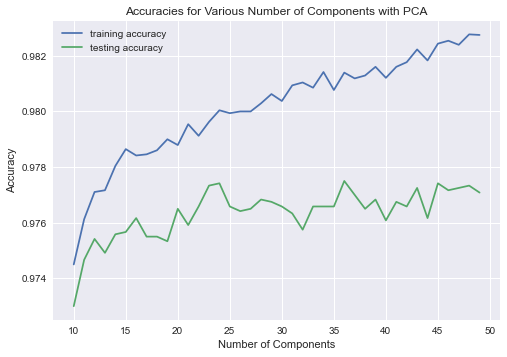

In [90]:
plt.plot(range(10, 50), train_scores, label='training accuracy')
plt.plot(range(10, 50), test_scores, label='testing accuracy')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title("Accuracies for Various Number of Components with PCA")
plt.legend()
plt.show()